## 1. Pendahuluan

Pada tugas akhir kursus data sains ini saya akan mencoba mendalami percakapan yang terjadi pada warganet seputar kebijakan pemerintah yang (pada awalnya) berencana untuk menaikkan PPKM pada libur natal dan tahun baru. Pada analisis ini, akan diungkap bagaimana opini yang beredar di masyarakat, sentimen, topik modelling, dan siapa yang memiliki pengaruh dominan dalam percakapan. Adapun data yang diolah diambil dari media sosial, dalam hal ini twitter. Data tersebut diambil pada interval 3 Desember 2021 hingga 6 Desember 2021. 

Pembahasan pada file notebook ini, terbagi menjadi beberapa bagian antara lain: 

1. pendahuluan
2. pengumpulan data 
3. pembacaan data
4. pembersihan data 
5. analisis teks
6. analisis sentimen
7. Network X
8. kesimpulan 

Catatan :

1. Ada beberapa file yang perlu disertakan pada saat menjalankan file notebook ini antara lain:
  - token.json : file json yang memuat nilai bearer token sebagai authentikasi akses api twitter. 
  - kata_positif.txt : dataset kata positif
  - kata_negatif.txt : dataset kata negatif
  - tweet_data.csv : dataset twitter yang telah diperoleh
  - tweet_data.bak.csv : backup dataset twitter yang telah diperoleh
  - requirements.txt : list dependensi python yang digunakan

2. Untuk menjalankan file notebook ini sebaiknya di run satu persatu cell-nya. Jika cell untuk query data ke api twitter dieksekusi, maka anda akan menunggu waktu yang cukup lama untuk mendapatkan semua berkas, file tweet_data.csv akan tertimpa dan kemungkinan terjadi error karena ada limitasi twitter yang hanya memperbolehkan akses data selama 7 hari kebelakang. (request data dilakukan pada interval 3 desember - 6 desember 2021)

3. Jika file tweet_data.csv tertimpa karena mengekseskusi run-all, maka gunakan tweet_data.bak.csv pada pembacaan file untuk mendapatkan hasil analisa yang serupa.

4. Jika ada module yang tidak support/ belum terinstall, silakan buat environment baru, dengan perintah : `python -m virtualenv env`. Aktivasi virual environment-nya dengan mengeksekusi activate.bat / activate pada folder env. kemudian install packagenya dengan `pip install -r requirements.txt` 


In [4]:
# general
import numpy as np
import math
import csv
import json
import time
from datetime import datetime, timedelta

# data gathering
import tweepy 
import requests
from bs4 import BeautifulSoup

# data frame & visualization
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# data cleaning
import re, string

# NLP module
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# topic modelling
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import tqdm

# Network X
import networkx as nx

## 2. Pengumpulan Data

Mari kita mulai dengan pengumpulan data dari media sosial twitter. Data dari twitter diperoleh dengan menggunakan api yang telah disediakan oleh twitter. Dalam hal ini, saya akan menggunakan pustaka tweepy untuk melakukan permintaan data. Tweepy merupakan pustaka yang bersifat opensource untuk mempermudah akses data ke server publik twitter. Pengguna pustaka ini cukup memasukan token pada parameter autentikasi, kemudian memilih metode permintaan sambil menyertakan parameter query-nya. 

Berikut adalah kode untuk mengakses data twitter dengan kata pencarian tertentu dan selang waktu tertentu. Selain dengan kata kunci permintaan data ditambah dengan filter bahasa yang digunakan (bahasa indonesia) dan mengecualikan retweet. Jumlah permintaan tweet harian dapat mencapai 600 tweet (hal ini beragantung kepada jumlah tweet yang tersedia di hari itu dan batasan waktu dari twitter). Karena ada batasan jumlah permintaan dalam pencarian twitter, maka dilakukan penundaan selama 15 menit (+5 detik) untuk melakukan request berikutnya dengan menggunakan metode time.sleep(). Setelah pencarian berhasil, data tweet disimpan dalam bentuk file csv dengan field : created_at, author_id, tweet, retweet_count, reply_count, like_count, reply_count, quote_count. 

Note : Karena server twitter menyimpan data dalam format utc, maka perlu konversi nilai datetime pada saat melakukan request. Misal ketika kita ingin melakukan permintaan pada tanggal 6 Desember 2021 20.00 WIB, maka permintaan yang dikirim adalah 6 Desember 2021 13.00. 

In [5]:
timeOffset = time.timezone/3600

def getUtcDateTime(localTime):
    localTime += timedelta(hours=timeOffset)
    return localTime

def getLocalDatetime(utcTime):
    utcTime -= timedelta(hours=timeOffset)
    return utcTime

class TwitterAPI:
    delay = (60*15)+5
    def __init__(self, tokenFile):
        self.readToken(tokenFile)
        self.createConnection()

    def readToken(self, tokenFile):
        with open(tokenFile) as f:
            self.token = json.load(f)

    def createConnection(self):
        self.client = tweepy.Client(
            bearer_token = self.token["bearer_token"], 
            wait_on_rate_limit=True
            )

    def getTweet(self, query, dateTime):
        responses = tweepy.Paginator(
            self.client.search_recent_tweets, 
            query=query,
            tweet_fields=['text', 'created_at', 'author_id', 'public_metrics'], 
            max_results=100, 
            end_time = dateTime, 
        ).flatten(limit=600)
        return responses
    
    def log(self, text):
        print(f"[script] {datetime.now()} : {text}")
        
    def crawl(self, query, dateTime, numberOfDays=1):
        mode="w"
        for i in range(numberOfDays):
            tweetData = []
            if (i!=0):
                mode="a"
                delayText =  f"{TwitterAPI.delay} seconds"
                if TwitterAPI.delay > 60:
                    minutes = math.floor(TwitterAPI.delay / 60)
                    secods = TwitterAPI.delay % 60
                    delayText =  f"{minutes} minutes {secods} seconds"
                self.log(f"wait for {delayText}")
                time.sleep(TwitterAPI.delay)

            self.log(f"request tweet before {getLocalDatetime(dateTime)}")
            
            responses = self.getTweet(query, dateTime)
            for (idx, response) in  enumerate(responses):
                # print(f'[{idx+1}] : {response.author_id}')
                # print(response.created_at, response.text)
                # print("-"*80)
                tweetData.append([
                    response.created_at,
                    response.author_id,
                    response.text,
                    response.public_metrics["retweet_count"],
                    response.public_metrics["like_count"],
                    response.public_metrics["reply_count"],
                    response.public_metrics["quote_count"]
                ])
            dateTime += timedelta(days=1)
            self.writeToCsv(tweetData, mode=mode)
        
        self.log("done")

    def writeToCsv(self, data, mode="w"):
        self.log("write to file") if (mode=="w") else self.log("append to file")
        with open('./tweet_data.csv', mode, encoding='UTF8', newline="") as f:
            writer = csv.writer(f)
            if (mode=="w"):
                header = ["created_at", "author_id", "tweet", "retweet", "like", "reply","quote"]
                writer.writerow(header)
            writer.writerows(data)


##### PERHATIAN :
- Menjalankan kode di bawah ini akan menimpa berkas tweet_data.csv dan membutuhkan waktu yang cukup lama. Oleh karena itu pastikan berkas tweet_data.csv sebelumnya dibackup terlebih dahulu. Adapun waktu yang diperlukan kurang lebih berkisar =  (numberOfDays-1) * (15 menit + 5 detik)
- Silakan di run untuk pengetesan, namun dilakukan penyesuaian tanggal terlebih dahulu. Karena twitter hanya memperbolehkan akses histori pada 7 hari kebelakang. Selanjutnya, timpa tweet_data.csv dengan tweet_data.bak.csv untuk digunakan dalam pengolahan.

In [1]:
# create twitterAPI object
tweet = TwitterAPI("./token.json")

# query parameter setup
query = 'ppkm - is:retweet lang:id'
startLocalTime = datetime(2021, 12, 3, 23, 59, 59)
startDateTime = getUtcDateTime(startLocalTime)
numberOfDays = 4

# crawl data
tweet.crawl(query, startDateTime, numberOfDays)

[script] 2021-12-10 21:37:00.365979 : request tweet before 2021-12-03 23:59:59
[script] 2021-12-10 21:37:01.737020 : write to file
[script] 2021-12-10 21:37:01.738975 : wait for 15 minutes 5 seconds
[script] 2021-12-10 21:52:06.750112 : request tweet before 2021-12-04 23:59:59
[script] 2021-12-10 21:52:10.404827 : append to file
[script] 2021-12-10 21:52:10.417323 : wait for 15 minutes 5 seconds
[script] 2021-12-10 22:07:15.426827 : request tweet before 2021-12-05 23:59:59
[script] 2021-12-10 22:07:19.470490 : append to file
[script] 2021-12-10 22:07:19.476482 : wait for 15 minutes 5 seconds
[script] 2021-12-10 22:22:24.476955 : request tweet before 2021-12-06 23:59:59
[script] 2021-12-10 22:22:28.481515 : append to file
[script] 2021-12-10 22:22:28.488524 : done


## 3. Pembacaan Data

Setelah data dikumpulkan, data disimpan ke dalam file berbentuk csv. Adapun data tweet yang akan diolah sebagai berikut
- created_at: Waktu dan tanggal tweet dalam format UTC, jika hendak dikonversi ke dalam waktu lokal indonesia, perlu dikonversi +7
- author_id : ID akun twitter warganet
- tweet : Text kicauan dari warganet
- retweet : Menunjukan jumlah berapa kali tweet dibagikan. Retweet berarti anda setuju dengan penulis sehingga anda ingin membagikan Tweet mereka dengan pengikut anda yang lain.
- reply : Menunjukan jumlah balasan. Komentar warganet terhadap tweet.
- like : Sejenis tanda bahwa seseorang menyukai atau setuju dengan Tweet.
- quote : Komentar warganet terhadap tweet dengan menyertakan tweet sebelumnya.

Data di atas akan diolah untuk analisis sentimen dan popularitas tweet. Untuk keperluan sentimen analisis diperlukan data tweet, sedangkan untuk mengetahui seberapa populer tweet tersebut akan diolah dari jumlah reply, like, retweet dan quote.


Pada sesi ini akan dilihat gambaran umum data mulai dari menujukkan sampel data, mengetahui jumlah tweet, informasi dataframe, memeriksa dan mengatasi  data yang hilang atau duplikat, dan menghitung statistika deskripsi.

In [6]:
def separation(text):
    print(f"\n{'-'*80}\n{text}\n{'-'*80}")


tweets = pd.read_csv("./tweet_data.csv")

separation("1.1 Sample Data")
display(tweets.head()) 

separation("1.2 Dimensi Data Frame")
print(f"Baris : {tweets.shape[0]}")
print(f"Kolom : {tweets.shape[1]}")

separation("1.3 Info Data Frame")
display(tweets.info())

separation("1.4 Duplikasi Data")
display(tweets[tweets.duplicated(subset=['tweet'])].head())



--------------------------------------------------------------------------------
1.1 Sample Data
--------------------------------------------------------------------------------


created_at            author_id  \
0  2021-12-03 16:57:34+00:00  1169863634261954562   
1  2021-12-03 16:57:30+00:00             65352152   
2  2021-12-03 16:55:35+00:00           1363887252   
3  2021-12-03 16:52:48+00:00  1414972896640786432   
4  2021-12-03 16:52:38+00:00  1409396291738628097   

                                               tweet  retweet  reply  like  \
0  Siap² semuanya ppkm lvl 4 di depan mata https:...        0      0     0   
1  @ccccladyana @ernestprakasa Iya soalnya ppkm l...        0      1     0   
2  @johyewoin Hey aku lagi ultah!😆 Gak ada soale ...        0      1     0   
3  Menjelang Nataru 2022, Begini Aturan Perayaan ...        0      0     0   
4  @mamadarling2021 Selamat pagi mam sekarang uda...        0      0     0   

   quote  
0      0  
1      0  
2      0  
3      0  
4      0


--------------------------------------------------------------------------------
1.2 Dimensi Data Frame
--------------------------------------------------------------------------------
Baris : 2030
Kolom : 7

--------------------------------------------------------------------------------
1.3 Info Data Frame
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030 entries, 0 to 2029
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  2030 non-null   object
 1   author_id   2030 non-null   int64 
 2   tweet       2030 non-null   object
 3   retweet     2030 non-null   int64 
 4   reply       2030 non-null   int64 
 5   like        2030 non-null   int64 
 6   quote       2030 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 111.1+ KB


None


--------------------------------------------------------------------------------
1.4 Duplikasi Data
--------------------------------------------------------------------------------


created_at            author_id  \
296  2021-12-04 15:05:35+00:00  1431184140796248064   
297  2021-12-04 15:05:22+00:00  1431184140796248064   
298  2021-12-04 15:05:12+00:00  1431184140796248064   
434  2021-12-04 12:15:17+00:00  1432847385802072067   
470  2021-12-04 11:45:00+00:00             39933002   

                                                 tweet  retweet  reply  like  \
296  @Humas_Polda_Ktg Presiden Apresiasi Penanganan...        0      0     0   
297  @Humas_Polda_Ktg Presiden Apresiasi Penanganan...        0      0     0   
298  @Humas_Polda_Ktg Presiden Apresiasi Penanganan...        0      0     0   
434  @Humas_Polda_Ktg Presiden Apresiasi Penanganan...        0      0     0   
470  Cegah lonjakan kasus Covid-19, ini aturan yang...        0      0     0   

     quote  
296      0  
297      0  
298      0  
434      0  
470      0

Pada bagan di atas diperoleh informasi sebagai berikut 

- Pada bagan sample data (1.1) menunjukkan bahwa kode pada bagian dua (pengumpulan data) efektif untuk mendapatkan field yang memuat waktu tweet, id penulis, tweet dan banyaknya retweet, reply, like dan quote.

- Jumlah tweet yang berhasil diperoleh adalah 2030 data, sebagaimana tertera pada bagan dimensi data frame (1.2)

- Dari 2030 data, tidak ditemukan data yang kosong. Dengan demikian tidak perlu dilakukan penanganan data kosong. Diketahui pula author_id, banyaknya retweet, reply, like dan quote bertipe integer. Sedangkan sisanya adalah objek. Mungkin perlu dikonversi nilai untuk nilai createdAt-nya menjadi time series. Untuk kemudian dipisahkan berdasarkan waktu.

- Terdapat duplikasi tweet data pada dataframe. Diduga duplikasi ini terjadi pada akun tertentu yang mencuit dengan teks yang sama pada waktu yang berbeda. Oleh karena itu, tweet yang ganda perlu dihapus, dan disisakan hanya satu saja.

In [7]:
tweets = tweets.drop_duplicates(subset=['tweet'])

separation("1.5 Data Setelah menghapus Duplikasi")
display(tweets)

separation("1.6 Statistik Deskripsi")
display(tweets.describe())



--------------------------------------------------------------------------------
1.5 Data Setelah menghapus Duplikasi
--------------------------------------------------------------------------------


created_at            author_id  \
0     2021-12-03 16:57:34+00:00  1169863634261954562   
1     2021-12-03 16:57:30+00:00             65352152   
2     2021-12-03 16:55:35+00:00           1363887252   
3     2021-12-03 16:52:48+00:00  1414972896640786432   
4     2021-12-03 16:52:38+00:00  1409396291738628097   
...                         ...                  ...   
2025  2021-12-06 09:25:56+00:00  1404645085959000073   
2026  2021-12-06 09:25:40+00:00  1375072384995061767   
2027  2021-12-06 09:24:52+00:00  1404645085959000073   
2028  2021-12-06 09:20:50+00:00  1296083962574458880   
2029  2021-12-06 09:17:49+00:00           2449041576   

                                                  tweet  retweet  reply  like  \
0     Siap² semuanya ppkm lvl 4 di depan mata https:...        0      0     0   
1     @ccccladyana @ernestprakasa Iya soalnya ppkm l...        0      1     0   
2     @johyewoin Hey aku lagi ultah!😆 Gak ada soale ...        0      1     0   
3     Menjelang Nataru 2022, Begini Aturan Perayaan ...        0      0     0   
4     @mamadarling2021 Selamat pagi mam sekarang uda...        0      0     0   
...                                                 ...      ...    ...   ...   
2025                        @aiiptu Dukung PPKM level 3        0      0     0   
2026  Pengetatan dn pengawasan prokes itu dilakukan ...       17      5    18   
2027                @kalla_jengking Dukung PPKM level 3        0      0     0   
2028  @lofibaeb Wes aman ges tahun baru ppkm+udas deren        0      0     0   
2029  @miko_stark Haha cutinya dimajukan sebelum tgl...        0      0     0   

      quote  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
2025      0  
2026      0  
2027      0  
2028      0  
2029      0  

[2000 rows x 7 columns]


--------------------------------------------------------------------------------
1.6 Statistik Deskripsi
--------------------------------------------------------------------------------


author_id      retweet        reply         like        quote
count  2.000000e+03  2000.000000  2000.000000  2000.000000  2000.000000
mean   8.055260e+17     0.519500     0.478500     3.307500     0.214500
std    6.104986e+17     5.873403     2.967312    83.001088     6.666762
min    1.694503e+07     0.000000     0.000000     0.000000     0.000000
25%    1.374764e+09     0.000000     0.000000     0.000000     0.000000
50%    1.121803e+18     0.000000     0.000000     0.000000     0.000000
75%    1.337769e+18     0.000000     1.000000     0.000000     0.000000
max    1.467312e+18   205.000000   120.000000  3578.000000   294.000000

- Setelah dilakukan penghapusan duplikasi data, diperoleh data 2000 tweet yang berbeda. 

- Retweet, rata-rata jumlah retweet 0.5 dengan standar deviasi 5.8. Nilai minimum 0 dan maksimumnnya 205. Dari 75% data terurut, datanya tidak ada yang di retweet sama sekali. 

- Reply, rata-rata jumlah reply 0.47 dengan standar deviasi 2.9. Nilai minimum 0 dan maksimumnnya 205. Dari 50% data terurut, datanya tidak ada yang di reply sama sekali. 

- Rata-rata like pada 2000 tweet adalah 3.3 dengan standar deviasi 83. Dengan standar deviasi ini, menunjukkan simpangan datanya cukup jauh dari rata-rata. 

- Dari 2000 tweet, rata-rata tweet yang dijadikan quote adalah 0.2 dengan standar deviasi 6.67. Dari 75% data terurut tidak ditemukan tweet yang di quote oleh warganet. 

- Dari data di atas, diperoleh kecenderungan warganet dari yang paling sering ke yang paling jarang : like > retweet > reply > quote

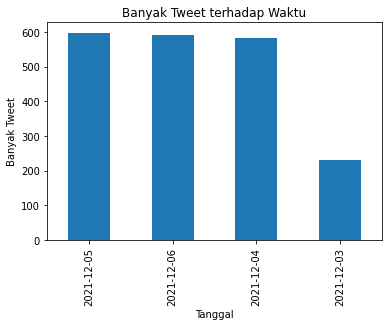

In [8]:
# Konversi tanggal
tweets["created_at"] = pd.to_datetime(tweets["created_at"]).apply(getLocalDatetime)
tweets["date"] = pd.to_datetime(tweets["created_at"], format="%Y%m%d").dt.date

plt.title("Banyak Tweet terhadap Waktu")
plt.ylabel("Banyak Tweet")
plt.xlabel("Tanggal")
tweets.date.value_counts().plot(kind="bar")
plt.show()


## 4. Data Cleaning

In [9]:
pd.set_option('display.max_colwidth', None)

class TweetAnalyzer:
  slangs = {
      "ya": "",
      "yg": "", 
      "dg": "", 
      "thd": "", 
      "dr": "", 
      "drpd": "",
      "aja": "",
      "jd": "",
      "lg": "",
      "tak": "tidak",
      "tdk": "tidak",
      "gak": "tidak", 
      "engga": "tidak",
      "enggak": "tidak", 
      "ga": "tidak", 
      "g": "tidak", 
      "blm": "belum",
      "tp": "tapi", 
      "belom": "belum", 
      "jgn": "jangan", 
      "bkn": "bukan", 
      "kalo": "", 
      "ttg": "", 
      "amp": "", 
      "pas":""
    }  

  def __init__(self, df):
    self.df = df.copy()
    self.blackList = stopwords.words('indonesian')
    self.cleanTweet()

  def cleanTweet(self):
    # 1. case folding
    # 2. remove / replace slangs
      # merubah / mengganti kata slang umum yang biasa 
      # digunakan dalam percakapan
      # untuk kata hubung, saya putuskan untuk menghapusnya, sedangkan untuk 
      # kata lain saya ganti dengan kata formal bahasa indonesia
    # 3. removeStopWords
    # 4. stemming

    self.df["tweet_clean"] = self.df["tweet"].apply(self.caseFolding)
    self.replaceSlang(slangs=TweetAnalyzer.slangs)
    self.df["tweet_clean"] = self.df["tweet_clean"].apply(self.removeStopWords)   
    # self.df["tweet_clean"] = self.df["tweet_clean"].apply(self.stemming) 

  def showHead(
    self,
    columns=["tweet", "id", "tweet_clean"],
    n=5
  ):
    display(self.df[columns].head(n)) 

  def caseFolding(self, text):
    # 1. convert to lower case
    # 2. replace digit & link with a whitespace 
    # 3. remove &amp \n or \t
    # 4. remove white space
    # 5. remove punctuation
    text = text.lower()
    text = re.sub(r"\d+|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    text = text.strip()
    text = text.translate(text.maketrans("", "", string.punctuation))
    return text
  
  def replaceSlang(self, slangs):
    self.df["tweet_clean"] = self.df["tweet_clean"].apply(self.replaceText, slangs=slangs)

  def replaceText(self, text, slangs):
    splittedText = word_tokenize(text)
    text = ""
    for word in splittedText:
        if word in slangs.keys():
            word = slangs[word] if slangs[word]!="" else ""    
        text += f" {word}"
    text = re.sub(' +', ' ', text)
    # splittedText = word_tokenize(text)
    # splittedText = [word if word not in slangs.keys() else (word if slangs[word]!="" else slangs[word]) for word in splittedText]
    # text = " ".join(splittedText)
    # text = re.sub(' +', ' ', text)
    return text

  def removeStopWords(self, text):
    text = word_tokenize(text)
    cleanText = [word for word in text if word not in self.blackList]
    return " ".join(cleanText) 

  def stemming(self, text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

  def showFqCharPerTweet(self):
    self.df["tweet_clean"].str.len().hist(bins=20)
    plt.title("Distribusi Frekuensi jumlah huruf pada suatu data")
    plt.show()

  def showNumWordPerTweet(self):
    self.df["tweet_clean"].str.split().map(lambda x: len(x)).hist(bins=20)
    plt.title("Distribusi Frekuensi jumlah kata pada suatu data")
    plt.show()
  
  def getAvgWord(self, x):
      x = x.split()
      x = map(lambda x: len(x), x)
      return(np.average(list(x)))

  def showAvgWordPerTweet(self):
    self.df["tweet_clean"].apply(self.getAvgWord).hist(bins=20)
    plt.title("Distribusi Frekuensi panjang kata rata-rata pada suatu data")
    plt.show()

  def genAllWord(self): 
    self.df["tokenize"] = self.df["tweet_clean"].apply(lambda x: x.split(" ")) 
    self.allWord = [word for tweet in self.df["tokenize"] for word in tweet]
    
  def freqWordDist(self, nWord=20):
    self.genAllWord()
    print("Distribusi Frekuensi kata yang sering keluar")
    fqdist = FreqDist(self.allWord)
    fqdist.plot(nWord, cumulative=False)

  def nGramsDist(self, n=2, nWord=20):
    self.genAllWord()
    result = pd.Series(ngrams(self.allWord, n)).value_counts()[:nWord]
    print(f"#Distribusi N-gram (n={n})")
    print(result)
  
  def genWordCloud(self):
    self.genAllWord()
    wordcloud = WordCloud(
      random_state=1,
      background_color='black',
      colormap='Pastel1', 
      max_words=100,
      collocations=False  
    ).generate(" ".join(self.allWord))
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis("off")

In [10]:
myTweet = TweetAnalyzer(tweets)
myTweet.df[["tweet", "tweet_clean"]]

tweet  \
0                                                                                                                                                                                                                      Siap² semuanya ppkm lvl 4 di depan mata https://t.co/IhFvMQV6oW   
1                                                                                                                                                                                                                                 @ccccladyana @ernestprakasa Iya soalnya ppkm level 3   
2                                                                                                                                                                            @johyewoin Hey aku lagi ultah!😆 Gak ada soale ppkm, tapi kalau jojo mau kirim kado boleh banget lhoooo :3   
3                                                                                                                                                      Menjelang Nataru 2022, Begini Aturan Perayaan Natal di Tengah PPKM Level 3\r\nhttps://t.co/YzCyhWA5VI\r\nProkes Lindungi Rakyat   
4                                                                                                                                                @mamadarling2021 Selamat pagi mam sekarang udah kgk ngarep adegan cium kening atau apalah kan sebentar lagi ppkm diberlakukan kembali   
...                                                                                                                                                                                                                                                                                ...   
2025                                                                                                                                                                                                                                                       @aiiptu Dukung PPKM level 3   
2026  Pengetatan dn pengawasan prokes itu dilakukan menyusul keputusan pemerintah yg akan menerapkan PPKM level 3 di seluruh wilayah Indonesia. konsistensi pemerintah menjadi kunci kebijakan itu dpt efektif mencegah lonjakan kasus Covid-19. Yuk waspada!! https://t.co/5cG57fxhWY   
2027                                                                                                                                                                                                                                               @kalla_jengking Dukung PPKM level 3   
2028                                                                                                                                                                                                                                 @lofibaeb Wes aman ges tahun baru ppkm+udas deren   
2029                                                                                                                                                                         @miko_stark Haha cutinya dimajukan sebelum tgl 20\r\nItu pun tidak bisa keluar kota krn ada isu PPKM Miko   

                                                                                                                                                                                       tweet_clean  
0                                                                                                                                                                                    ppkm lvl mata  
1                                                                                                                                                                                   iya ppkm level  
2                                                                                                                                               hey ultah soale ppkm jojo kirim kado banget lhoooo  
3                                                                                                   

## 5. Analisis Teks

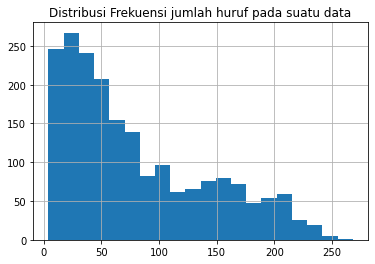

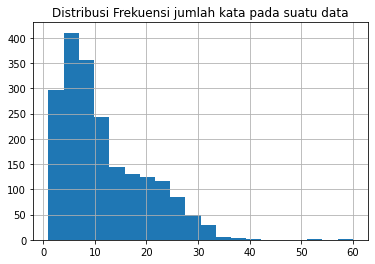

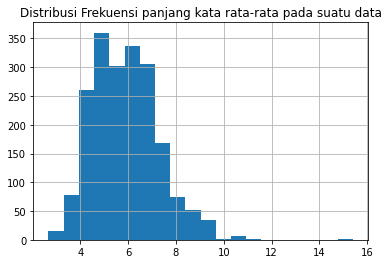

Distribusi Frekuensi kata yang sering keluar


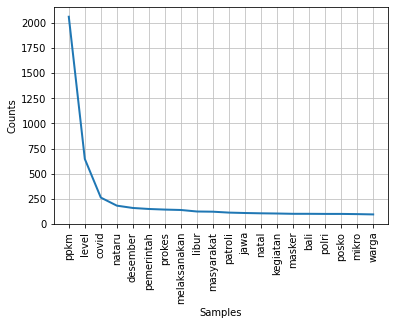

#Distribusi N-gram (n=2)
(ppkm, level)                   527
(jawa, bali)                     92
(protokol, kesehatan)            79
(ppkm, jawa)                     73
(ppkm, mikro)                    71
(posko, ppkm)                    68
(rt, desa)                       57
(tingkat, rt)                    56
(ppkm, ppkm)                     53
(dukung, ppkm)                   51
(level, polri)                   48
(optimalisasi, posko)            47
(nataru, merujuk)                47
(melaksanakan, optimalisasi)     47
(pos, melaksanakan)              47
(persiapkan, menggelar)          47
(polri, persiapkan)              47
(regulasi, level)                47
(menggelar, pos)                 47
(diterapkan, regulasi)           47
dtype: int64


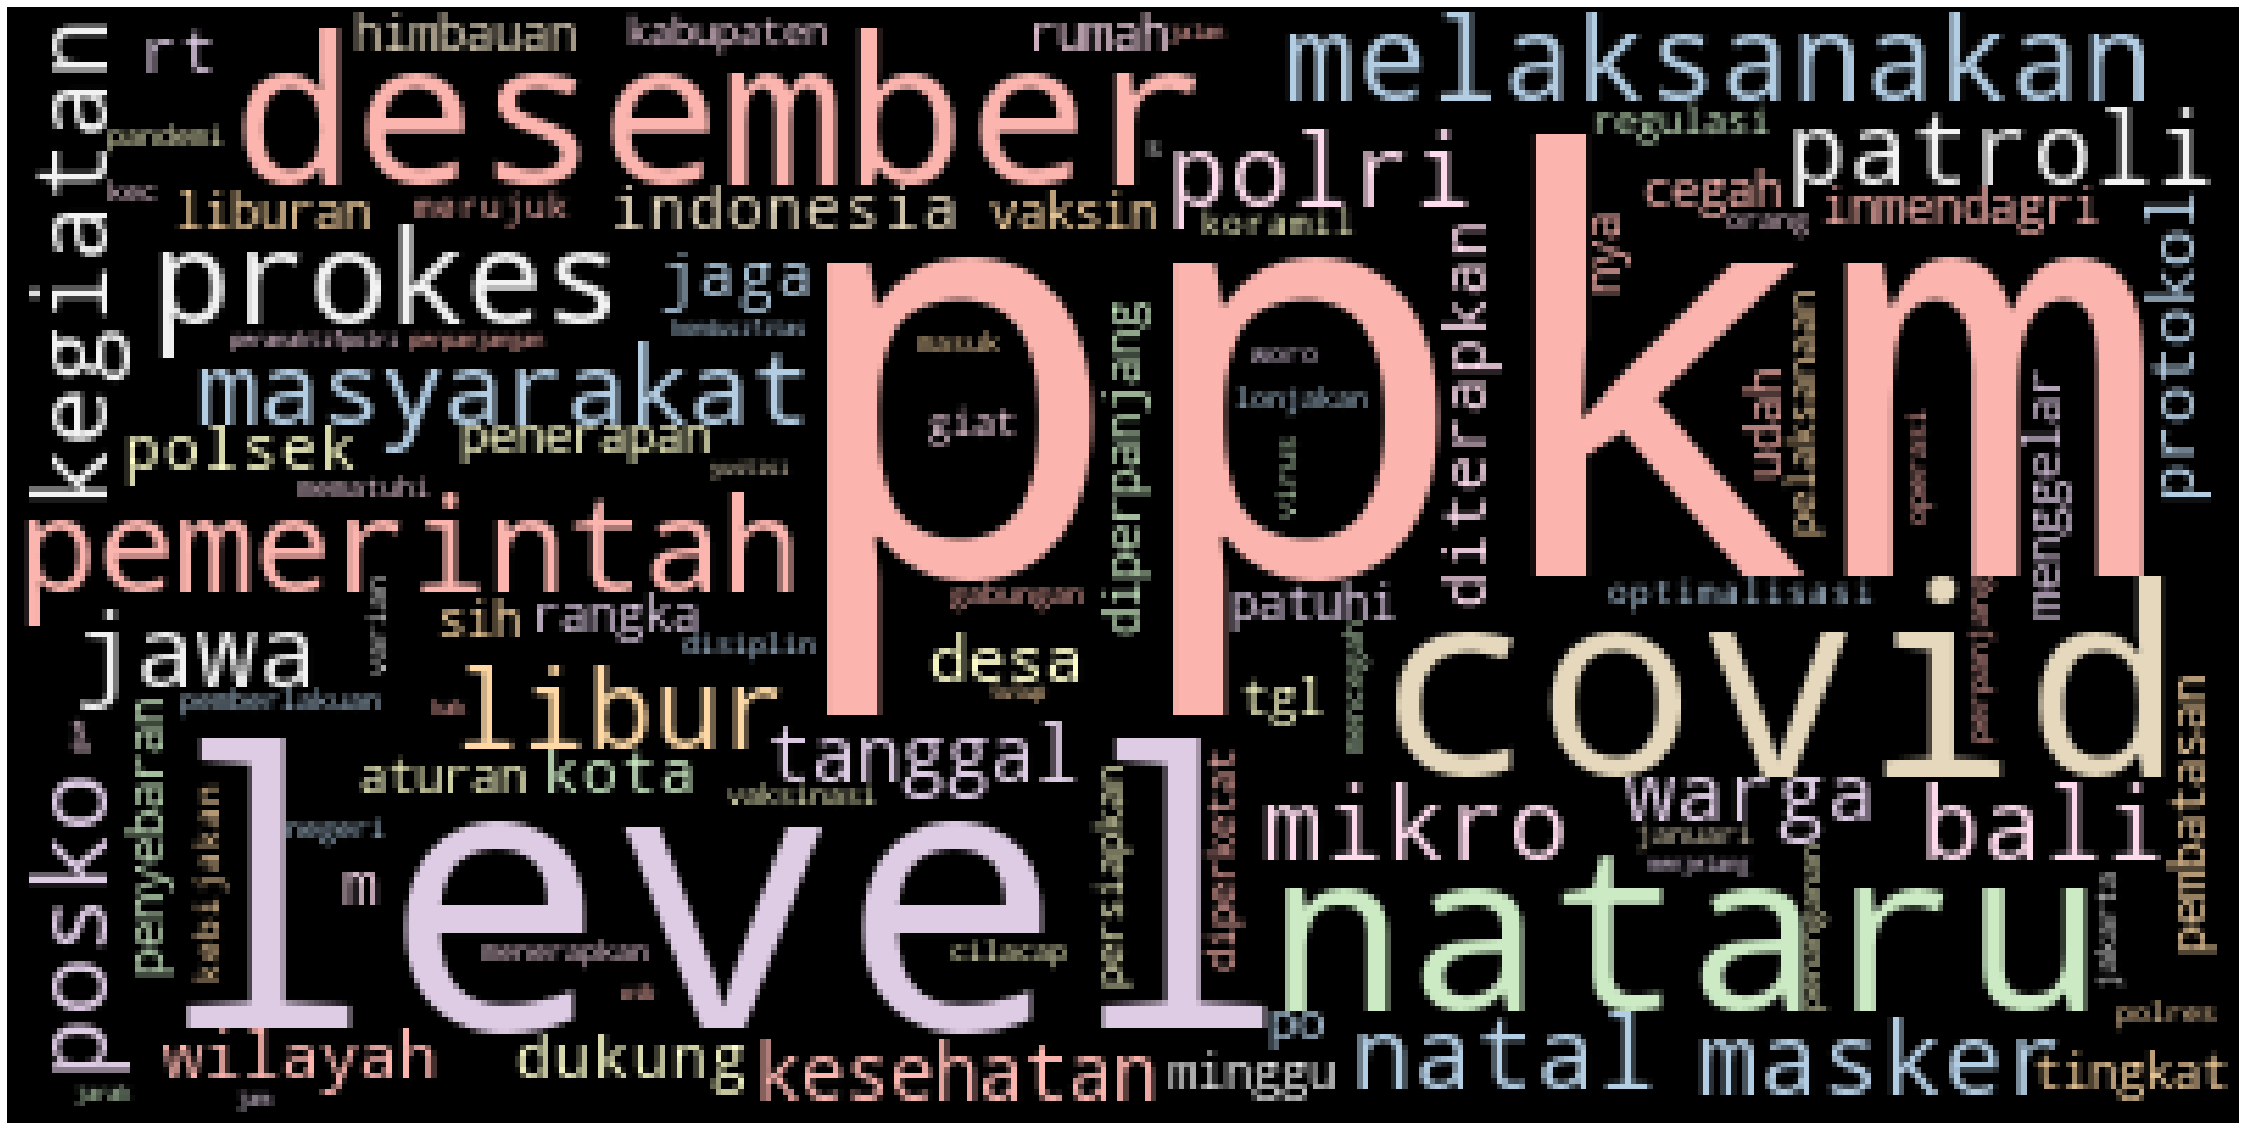

In [11]:
# Distribusi Frekuensi karakter per tweet
myTweet.showFqCharPerTweet()
# Distribusi panjang kata per tweet
myTweet.showNumWordPerTweet()
# Distribusi panjang rata-rata kata per tweet
myTweet.showAvgWordPerTweet()
# Distribusi Kata
myTweet.freqWordDist()
# Word Cloud
myTweet.genWordCloud()
# Distribusi N-Gram
myTweet.nGramsDist()


In [12]:
tweets["popularity"] = tweets["like"]+ 2*tweets["reply"] + 3*tweets["retweet"] + 2*tweets["quote"] 
tweets[["author_id", "tweet", "popularity"]].sort_values(["popularity"], ascending=False).head(10)

author_id  \
869              78281129   
1897  1344453038140899329   
1821           2412572689   
1010            104556071   
945             104556071   
786   1302817673105928192   
754   1272953532535062529   
572   1372552023640395781   
756            1374763538   
707             322559270   

                                                                                                                                                                                                                                                                                                                           tweet  \
869                                                @schfess Kalo emang mau mencegah mobilitas anak-anak pas libur natal &amp; tahun baru, mending bukan liburnya yg ditunda/dihapus tp bisa dg menutup tempat wisata, membatasi kunjungan mall dsb. Akhir tahun mau diterapkan ppkm lvl 3 serentak kan? Ketatkan saja aturannya.   
1897                                                                                                                                                                                                                                                                                                     @callaliIie sirkel ppkm   
1821                                                                                                                                                                             Cuma Di Indonesia, Arwah hilir mudik gak takut PPKM..\r\n\r\nhadeuhh Indonesia...\r\nOrang mah kalo dah mati.. mati aja https://t.co/fw4HcbRBr7   
1010                                                                        INFO | Sehubungan dengan diberlakukannya PPKM Level 2, per 6 Desember 2021, layanan Transjakarta beroperasi pada pukul 05:00 - 21:30 WIB. Sedangkan Layanan nakes dan AMARI beroperasi pada 21:31 - 22:30 WIB sesuai SK Kadishub No. 485 Tahun 2021.   
945              Sahabat Tije, menyesuaikan dengan ditetapkannya PPKM level 2 di DKI Jakarta, layanan Transjakarta kembali menyesuaikan jam operasional menjadi pukul 05.00 - 21.30 WIB.\r\n\r\nAngkutan Malam Hari (AMARI) dan layanan khusus bagi tenaga kesehatan beroperasi pukul 21.31 - 22.30 WIB. https://t.co/qmb3odMmW7   
786       3.Anggota Komisi IX DPR Netty Prasetyani meminta pemerintah untuk perpanjang PPKM untuk mencegah lonjakan kasus Covid-19. Netty meminta agar pemerintah memperketat penjagaan di pintu pintu masuk kedatangan hususnya dr lua negeri. \r\n\r\n#DPRUntukNegeri terus mendengar aspirasi rakyat. https://t.co/1uWx6Gi8Ml   
754         Pemerintah memastikan bahwa pelaksanaan level 3 jelang Natal dan Tahun Baru 2022 tetap akan dilakukan pada akhir tahun ini meskipun ada varian baru covid yakni omicron. \r\n\r\nSeperti diketahui penerapan level 3 PPKM akan berlaku sejak tanggal 24 Desember sampai 2 Januari mendatang. https://t.co/gDGafMKpsm   
572                                                                                                                                                                 Bersatu Lawan Covid!!!\r\n\r\nPenerapan aturan PPKM Level 3 menjadi kebijakan tepat untuk menghalau Lonjakan Cov19.\r\n\r\nDukung!!! https://t.co/77DAZf3MqG   
756   Pemerintah tidak akan bosen" nya untuk mengingatkan kita sehubungan dengan masih berlangsungnya Pandemi.\r\n\r\nKebijakan Pemerintah menerapkan PPKM level 3 sdh tepat utk mengantisipasi muunculnya gelombang ketiga.\r\n\r\nVaksinasi juga sangat perlu maka bagi kita yg blm,ayo trima Vaksin 📌 https://t.co/sVj2Y3rN9B   
707                                                     Kita harus mendukung penuh upaya pemerintah dalam penanganan Pandemi Covid-19 dengan menerapkan PPKM level 3.\r\n\r\nJangan kasih kendor agar seluruh masyarakat untuk segera melakukan vaksinasi demi terwujudnya herd imunity secara Nasional. https://t.co/T7Y8yqw4Xv   

      popularity  
869         4315  
1897        1823  
1821         975  
1010         160  
945          155  
786          128 

Pada visualisasi di atas diperoleh informasi berikut:
- Mayoritas, jumlah karakter dalam satu data tweet berkisar antara 0-50 karakter, dengan kisaran 75% data berada pada sisi kiri. Distribusi condong ke arah kiri. Distribusi ini serupa dengan jumlah kata dalam satu tweet dengan jumlah 5-10 kata per tweet.
- Rata-rata jumlah kata yang digunakan adalah 5-7 karakter dalam satu kata.
- Pada plot frekuensi kata yang paling sering muncul (baik pada plot frekuensi atau bi-grams ) tidak terdapat kata-kata slangs atau kata yang tidak memiliki makna. Hal ini menunjukkan, nampaknya pembersihan telah cukup baik. 



Analisa Topik dari Frekuensi Kata dan Bigrams

Untuk mengetahui perbincangan warganet pada twitter, bisa kita lihat dari kata kunci yang sering muncul pada dataset. Jika ditelaah isu yang dibicarakan adalah pemberlakuan ppkm yang dilakukan oleh pemerintah pada hari libur natal dan tahun baru. Masyarakat diminta melaksanakan protokol kesehatan dan pembatasan kegiatan untuk menekan penyebaran covid-19. Selain itu aparat diminta untuk melakukan patroli dan ada peran serta masyarakat sampai level RT Desa untuk mensukseskan kebijakan ini. Adapun perbincangan warganet berfokus pada ketetapan yang dilakukan di jawa dan bali. Muncul pasangan kata "dukung ppkm" pada bi-grams, hal ini menunjukkan warganet sepakat dengan rencana yang diusulkan oleh pemerintah.  

## 6. Analisis Sentimen 

Pada bagian ini, saya akan coba melihat sentimen masyarakat. Metode analisis ini adalah dengan menghitung setiap kata / pasangan kata positif/negatif yang terdapat pada dataset tweet. Kemudian dibandingkan jumlah kemunculan kata positif dan negatifnya. Tweet positif, negatif atau netral dilihat dari mana kata yang paling sering muncul pada tweet tersebut. Kemudian akan diplot distribusi sentimen tweet pada dataset ini.

Setelah dihitung nilai sentimen, data set akan dibagi menjadi tiga, sentimen positif, netral dan negatif. Kemudian, akan kita lihat opini yang muncul masing-masing kelompok data dengan menggunakan frekeunsi kata dan bigram. Selanjutnya akan kita lihat juga tweet mana yang memiliki popularitas yang tinggi. Popularitas tweet dilihat dari banyaknya like, reply, retweet dan quote. Perhitungan popularitas ini dihitung dari formula berikut 

nilai_popularitas = like + 2 * reply + 3 * retweet + 2 * quote


### 6.1. Analisis Sentimen 

In [13]:
def readList(fileName):
    tFile = open(fileName, "r")
    result = tFile.readlines()    
    return [word.strip() for word in result]    

negations = ['tidak','lawan','anti', 'jangan', 'bukan', 'sulit', 'tak']
positiveWord = readList(f"./kata_positif.txt")
negativeWord = readList(f"./kata_negatif.txt")

sentimentValues = []

def getSentiment(text):
    splittedText = text.split()
    numPositive = 0
    numNegative = 0

    for idx, word in enumerate(splittedText):
        if word in positiveWord:
            if (splittedText[idx-1] in negations):
                numNegative+=1
                # print(splittedText[idx-1], word, ": negative")
            else :
                numPositive+=1
                # print(word, ": positive")
        
        elif word in negativeWord:
            if (splittedText[idx-1] in negations):
                numPositive+=1
                # print(splittedText[idx-1], word, ": positive")
            else :
                numNegative+=1
                # print(word, ": negative")

    # print("positive", numPositive)
    # print("negative", numNegative)
    value = numPositive-numNegative
    # print(value)
    sentimentValues.append(value)
    return "positive" if value>0 else "negative" if value<0 else "netral"

myTweet.df["sentiment"] = myTweet.df["tweet_clean"].apply(getSentiment)
myTweet.df["sValue"] = sentimentValues
myTweet.df[["tweet", "tweet_clean","sValue", "sentiment"]]


tweet  \
0                                                                                                                                                                                                                      Siap² semuanya ppkm lvl 4 di depan mata https://t.co/IhFvMQV6oW   
1                                                                                                                                                                                                                                 @ccccladyana @ernestprakasa Iya soalnya ppkm level 3   
2                                                                                                                                                                            @johyewoin Hey aku lagi ultah!😆 Gak ada soale ppkm, tapi kalau jojo mau kirim kado boleh banget lhoooo :3   
3                                                                                                                                                      Menjelang Nataru 2022, Begini Aturan Perayaan Natal di Tengah PPKM Level 3\r\nhttps://t.co/YzCyhWA5VI\r\nProkes Lindungi Rakyat   
4                                                                                                                                                @mamadarling2021 Selamat pagi mam sekarang udah kgk ngarep adegan cium kening atau apalah kan sebentar lagi ppkm diberlakukan kembali   
...                                                                                                                                                                                                                                                                                ...   
2025                                                                                                                                                                                                                                                       @aiiptu Dukung PPKM level 3   
2026  Pengetatan dn pengawasan prokes itu dilakukan menyusul keputusan pemerintah yg akan menerapkan PPKM level 3 di seluruh wilayah Indonesia. konsistensi pemerintah menjadi kunci kebijakan itu dpt efektif mencegah lonjakan kasus Covid-19. Yuk waspada!! https://t.co/5cG57fxhWY   
2027                                                                                                                                                                                                                                               @kalla_jengking Dukung PPKM level 3   
2028                                                                                                                                                                                                                                 @lofibaeb Wes aman ges tahun baru ppkm+udas deren   
2029                                                                                                                                                                         @miko_stark Haha cutinya dimajukan sebelum tgl 20\r\nItu pun tidak bisa keluar kota krn ada isu PPKM Miko   

                                                                                                                                                                                       tweet_clean  \
0                                                                                                                                                                                    ppkm lvl mata   
1                                                                                                                                                                                   iya ppkm level   
2                                                                                                                                               hey ultah soale ppkm jojo kirim kado banget lhoooo   
3                                                                                               

Nilai rata-rata: 0.0675
Standar deviasi: 0.9596581422569185


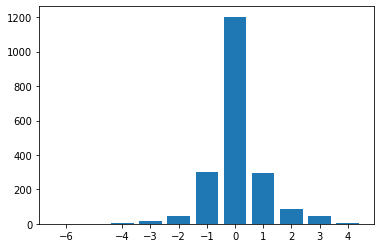

In [16]:
print (f"Nilai rata-rata: {np.mean(sentimentValues)}")
print (f"Standar deviasi: {np.std(sentimentValues)}")

labels, counts = np.unique(sentimentValues, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

Telah dilakukan perhitungan sentimen terhadap tiap tweet. Berikut adalah resume analisis sentimennya:

- Dari data tersebut diperoleh nilai rata-rata 0.075. Hal ini menyatakan bahwa warganet memiliki kecenderungan memiliki sentimen positif atas kebijakan pemerintah. 
- Karena data memiliki nilai standar deviasi 0.98, maka secara umum nilai sentimen tidak jauh berbeda dengan nilai rata-rata. 
- Sebaran-nya menyerupai distribusi normal dengan dominasi pada sentimen netral. 


Catatan

- Nampaknya perlu dikembangkan lagi algoritma untuk menghitung sentimen ini, karena sejauh ini yang dilakukan adalah membandingkan tiap kata pada tweet dengan dataset kata_positif dan kata_negatif. Sayangnya, dataset kata_positif tidak dalam bentuk kata dasar, jadi ada beberapa kata yang tidak tercover. Sebagai contoh pada tweet dengan indeks 3 : terdapat kata "lindungi" yang secara logika termasuk kata positif. Namun dianggap sebagai tweet netral karena pada dataset kata_positif hanya terdapat kata "melindungi" dan "dilindungi". Adapun pengembangan algoritma ini bisa dilakukan dengan melakukan memperkaya dataset atau mengubah algoritma penentuan sentimen. 

### 6.2. Tweet Populer

In [17]:
newDf = myTweet.df.copy()
newDf["popularity"] = 2*newDf["reply"] + newDf["like"] + 3*newDf["retweet"] + 2*newDf["quote"]
newDf = newDf[["tweet","tweet_clean", "author_id", "sentiment", "popularity"]]
newDf[["tweet", "author_id", "sentiment", "popularity"]].sort_values(["popularity"], ascending=False).head(10)

tweet  \
869                                                @schfess Kalo emang mau mencegah mobilitas anak-anak pas libur natal &amp; tahun baru, mending bukan liburnya yg ditunda/dihapus tp bisa dg menutup tempat wisata, membatasi kunjungan mall dsb. Akhir tahun mau diterapkan ppkm lvl 3 serentak kan? Ketatkan saja aturannya.   
1897                                                                                                                                                                                                                                                                                                     @callaliIie sirkel ppkm   
1821                                                                                                                                                                             Cuma Di Indonesia, Arwah hilir mudik gak takut PPKM..\r\n\r\nhadeuhh Indonesia...\r\nOrang mah kalo dah mati.. mati aja https://t.co/fw4HcbRBr7   
1010                                                                        INFO | Sehubungan dengan diberlakukannya PPKM Level 2, per 6 Desember 2021, layanan Transjakarta beroperasi pada pukul 05:00 - 21:30 WIB. Sedangkan Layanan nakes dan AMARI beroperasi pada 21:31 - 22:30 WIB sesuai SK Kadishub No. 485 Tahun 2021.   
945              Sahabat Tije, menyesuaikan dengan ditetapkannya PPKM level 2 di DKI Jakarta, layanan Transjakarta kembali menyesuaikan jam operasional menjadi pukul 05.00 - 21.30 WIB.\r\n\r\nAngkutan Malam Hari (AMARI) dan layanan khusus bagi tenaga kesehatan beroperasi pukul 21.31 - 22.30 WIB. https://t.co/qmb3odMmW7   
786       3.Anggota Komisi IX DPR Netty Prasetyani meminta pemerintah untuk perpanjang PPKM untuk mencegah lonjakan kasus Covid-19. Netty meminta agar pemerintah memperketat penjagaan di pintu pintu masuk kedatangan hususnya dr lua negeri. \r\n\r\n#DPRUntukNegeri terus mendengar aspirasi rakyat. https://t.co/1uWx6Gi8Ml   
754         Pemerintah memastikan bahwa pelaksanaan level 3 jelang Natal dan Tahun Baru 2022 tetap akan dilakukan pada akhir tahun ini meskipun ada varian baru covid yakni omicron. \r\n\r\nSeperti diketahui penerapan level 3 PPKM akan berlaku sejak tanggal 24 Desember sampai 2 Januari mendatang. https://t.co/gDGafMKpsm   
572                                                                                                                                                                 Bersatu Lawan Covid!!!\r\n\r\nPenerapan aturan PPKM Level 3 menjadi kebijakan tepat untuk menghalau Lonjakan Cov19.\r\n\r\nDukung!!! https://t.co/77DAZf3MqG   
756   Pemerintah tidak akan bosen" nya untuk mengingatkan kita sehubungan dengan masih berlangsungnya Pandemi.\r\n\r\nKebijakan Pemerintah menerapkan PPKM level 3 sdh tepat utk mengantisipasi muunculnya gelombang ketiga.\r\n\r\nVaksinasi juga sangat perlu maka bagi kita yg blm,ayo trima Vaksin 📌 https://t.co/sVj2Y3rN9B   
707                                                     Kita harus mendukung penuh upaya pemerintah dalam penanganan Pandemi Covid-19 dengan menerapkan PPKM level 3.\r\n\r\nJangan kasih kendor agar seluruh masyarakat untuk segera melakukan vaksinasi demi terwujudnya herd imunity secara Nasional. https://t.co/T7Y8yqw4Xv   

                author_id sentiment  popularity  
869              78281129  negative        4315  
1897  1344453038140899329    netral        1823  
1821           2412572689  negative         975  
1010            104556071  positive         160  
945             104556071  positive         155  
786   1302817673105928192    netral         128  
754   1272953532535062529    netral         107  
572   1372552023640395781    netral         100  
756            1374763538  positive          96  
707             322559270  positive          94

Tabel di atas merupakan tweet yang telah diurutkan dari tingkat popularitas. Diperoleh 3 tweet negatif, 3 tweet netral dan 4 tweet positif. Meskipun terdapat lebih banyak tweet positif, tapi nilai popularitas tweet negatif jauh lebih tinggi.

### 6.3. Opini Tiap Kelompok

Pada Bagian ini akan kita coba eksplorasi lebih dalam mengenai bagaimana opini pada kelompok dengan sentimen negatif dan positif.

In [18]:
def genAllWord(tweets):
    allWords = []
    for tweet in tweets:
        tokenize = tweet.split()
        for word in tokenize:
            allWords.append(word)
    return allWords

def freqWordDist(words, nWord=20):
    print("Distribusi Frekuensi kata yang sering keluar")
    fqdist = FreqDist(words)
    fqdist.plot(nWord, cumulative=False)
    # print(fqdist.most_common(20))

def nGramsDist(words, n=2, nWord=20):
    result = pd.Series(ngrams(words, n)).value_counts()[:nWord]
    print(f"#Distribusi N-gram (n={n})")
    print(result)

def genWordCloud(words):
    wordcloud = WordCloud(
      random_state=1,
      background_color='black',
      colormap='Pastel1', 
      max_words=100,
      collocations=False  
    ).generate(" ".join(words))
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis("off")


def showResume(df, group):
    separation(f"Kelompok dengan sentimen {group}")
    tweet =df[df.sentiment==group]
    display(tweet.sort_values(["popularity"], ascending=False).head())
    words = genAllWord(tweet.tweet_clean)
    freqWordDist(words)
    # genWordCloud(words)
    nGramsDist(words, n=2, nWord=10)



#### a. Kelompok Positif


--------------------------------------------------------------------------------
Kelompok dengan sentimen positive
--------------------------------------------------------------------------------


tweet  \
1010                                                                        INFO | Sehubungan dengan diberlakukannya PPKM Level 2, per 6 Desember 2021, layanan Transjakarta beroperasi pada pukul 05:00 - 21:30 WIB. Sedangkan Layanan nakes dan AMARI beroperasi pada 21:31 - 22:30 WIB sesuai SK Kadishub No. 485 Tahun 2021.   
945              Sahabat Tije, menyesuaikan dengan ditetapkannya PPKM level 2 di DKI Jakarta, layanan Transjakarta kembali menyesuaikan jam operasional menjadi pukul 05.00 - 21.30 WIB.\r\n\r\nAngkutan Malam Hari (AMARI) dan layanan khusus bagi tenaga kesehatan beroperasi pukul 21.31 - 22.30 WIB. https://t.co/qmb3odMmW7   
756   Pemerintah tidak akan bosen" nya untuk mengingatkan kita sehubungan dengan masih berlangsungnya Pandemi.\r\n\r\nKebijakan Pemerintah menerapkan PPKM level 3 sdh tepat utk mengantisipasi muunculnya gelombang ketiga.\r\n\r\nVaksinasi juga sangat perlu maka bagi kita yg blm,ayo trima Vaksin 📌 https://t.co/sVj2Y3rN9B   
707                                                     Kita harus mendukung penuh upaya pemerintah dalam penanganan Pandemi Covid-19 dengan menerapkan PPKM level 3.\r\n\r\nJangan kasih kendor agar seluruh masyarakat untuk segera melakukan vaksinasi demi terwujudnya herd imunity secara Nasional. https://t.co/T7Y8yqw4Xv   
758                                                               Bersatu kita melawan covid-19.\r\nCara yang tepat adalah dengan PPKM level 3.\r\nPemerintah membuat suatu kebijakan PPKM level 3 untuk meminimalisir lonjakan kasus covid-19 varian Omicron gelombang ketiga.\r\n@jokowi Lawan Pandemi https://t.co/sLLJVA8qL8   

                                                                                                                                                                                   tweet_clean  \
1010                                          info sehubungan diberlakukannya ppkm level desember layanan transjakarta beroperasi wib layanan nakes amari beroperasi wib sesuai sk kadishub no   
945   sahabat tije menyesuaikan ditetapkannya ppkm level dki jakarta layanan transjakarta menyesuaikan jam operasional wib angkutan malam amari layanan khusus tenaga kesehatan beroperasi wib   
756            pemerintah bosen nya sehubungan berlangsungnya pandemi kebijakan pemerintah menerapkan ppkm level sdh utk mengantisipasi muunculnya gelombang ketiga vaksinasi ayo trima vaksin   
707                                        mendukung penuh upaya pemerintah penanganan pandemi covid menerapkan ppkm level kasih kendor masyarakat vaksinasi terwujudnya herd imunity nasional   
758                                                bersatu melawan covid ppkm level pemerintah kebijakan ppkm level meminimalisir lonjakan covid varian omicron gelombang ketiga lawan pandemi   

       author_id sentiment  popularity  
1010   104556071  positive         160  
945    104556071  positive         155  
756   1374763538  positive          96  
707    322559270  positive          94  
758   2907040202  positive          89

Distribusi Frekuensi kata yang sering keluar


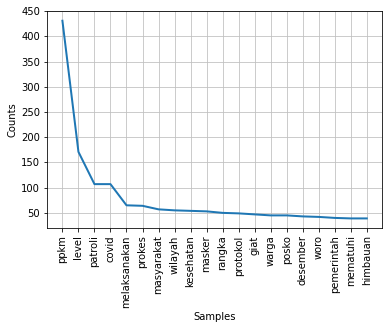

#Distribusi N-gram (n=2)
(ppkm, level)              158
(protokol, kesehatan)       49
(melaksanakan, patroli)     35
(patroli, ppkm)             28
(pelaksanaan, ppkm)         28
(giat, patroli)             23
(penanganan, covid)         21
(woro, woro)                21
(perpanjangan, ppkm)        19
(posko, penanganan)         19
dtype: int64


In [19]:
showResume(newDf, "positive")

#### b. Kelompok Negatif


--------------------------------------------------------------------------------
Kelompok dengan sentimen negative
--------------------------------------------------------------------------------


tweet  \
869                   @schfess Kalo emang mau mencegah mobilitas anak-anak pas libur natal &amp; tahun baru, mending bukan liburnya yg ditunda/dihapus tp bisa dg menutup tempat wisata, membatasi kunjungan mall dsb. Akhir tahun mau diterapkan ppkm lvl 3 serentak kan? Ketatkan saja aturannya.   
1821                                                                                                                                                Cuma Di Indonesia, Arwah hilir mudik gak takut PPKM..\r\n\r\nhadeuhh Indonesia...\r\nOrang mah kalo dah mati.. mati aja https://t.co/fw4HcbRBr7   
663                          Tidak ada pilihan lain... mari kita lawan Covid19 dengan tingkatkan disiplin Protokol Kesehatan. Dan jangan lupa patuhi aturan PPKM akan diterapkan Pemerintah mulai 24/12/2021 s.d. 02/01/2022 u/ meminimalisir lonjakan Covid19 gelombang 3. https://t.co/kbVRBm6E7r   
752   Kita sama-sama lawan Copit19 . PPKM level 3/2 harus kita patuhi. Ingat mencegah lebih baik.\r\nKebijakan ini ditetapkan dengan tujuan mengatur mobilitas masyarakat pada Nataru agar gelombang ketiga tidak terjadi.\r\n\r\nSaran, Nataru mendingan di rumah saja.👍🏽🙏 https://t.co/V5TNkhPoFG   
2018                                                            Menko PMK Muhadjir Effendy mengatakan, penerapan kebijakan pemberlakuan pembatasan kegiatan masyarakat (PPKM) level 3 di seluruh wilayah Indonesia akan berlaku mulai 24 Desember 2021.\r\n\r\n@bevan_hanie https://t.co/UsdKoh0TbX   

                                                                                                                                                                      tweet_clean  \
869   emang mencegah mobilitas anak anak libur natal mending liburnya ditunda dihapus menutup wisata membatasi kunjungan mall dsb diterapkan ppkm lvl serentak ketatkan aturannya   
1821                                                                                             indonesia arwah hilir mudik takut ppkm hadeuhh indonesia orang mah dah mati mati   
663                    pilihan mari lawan covid tingkatkan disiplin protokol kesehatan lupa patuhi aturan ppkm diterapkan pemerintah s d u meminimalisir lonjakan covid gelombang   
752                         lawan copit ppkm level patuhi mencegah kebijakan ditetapkan tujuan mengatur mobilitas masyarakat nataru gelombang ketiga saran nataru mendingan rumah   
2018                               menko pmk muhadjir effendy penerapan kebijakan pemberlakuan pembatasan kegiatan masyarakat ppkm level wilayah indonesia berlaku desember hanie   

                author_id sentiment  popularity  
869              78281129  negative        4315  
1821           2412572689  negative         975  
663   1274603373791113216  negative          89  
752   1373907751311532034  negative          81  
2018            307856074  negative          79

Distribusi Frekuensi kata yang sering keluar


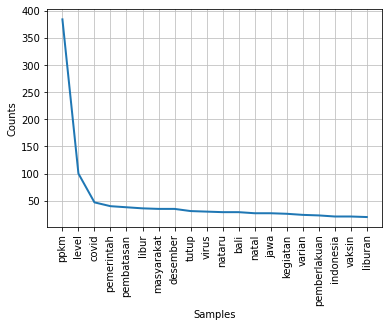

#Distribusi N-gram (n=2)
(ppkm, level)                 79
(jawa, bali)                  24
(kegiatan, masyarakat)        22
(pembatasan, kegiatan)        21
(masyarakat, ppkm)            21
(ppkm, jawa)                  20
(pemberlakuan, pembatasan)    20
(virus, varian)               20
(cegah, virus)                19
(ppkm, cegah)                 19
dtype: int64


In [20]:
showResume(newDf, "negative")

Berdasarkan plot jumlah kata, wordcloud dan distribusi n-grams baik pada kelompok dengan sentimen positif dan negatif, meski tidak nampak perbedaan opini secara dominan. Ada beberapa kata yang muncul hanya pada kelompok tertentu (untuk 20 kata terbanyak), antara lain :

##### - Kelompok Positif 

keyword : patroli, melaksanakan, prokes, wilayah, kesehatan, masker, rangka, protokol, giat, warga, posko, woro, mematuhi, himbauan

Kelompok positif konsern terhadap himbauan kepada masyarakat / aparat untuk melaksanakan prokes selama ppkm di akhir tahun. 


##### - Kelompok Negatif

keyword : pembatasan, libur, masyarakat, tutup, virus, bali, natal, varian, vaksin, 

Pada kelompok negatif, dugaan saya mereka keberatan dengan diberlakukan ppkm di akhir tahun karena adanya pembatasan dan penutupan aktifitas yang penting dan memberikan dampak bagi mereka. Misalnya kegiatan ekonomi yang awalnya berangsur pulih, tapi kembali harus dibatasi. Atau momen liburan yang dinanti harus dibatalkan, dsb. Mereka juga mungkin mempertanyakan dengan vaksin yang selama ini sudah dijalani. 

##### - Popularitas Tweet

Nilai popularitas tweet pada masing-masing kelompok yang bisa dilihat di tabel, nampak bahwa tweet dengan sentimen negatif lebih populer dari pada tweet dengan sentimen positif. Peringkat pertama tweet pada sentimen negatif mencapai nilai popularitas 4315, jauh sekali dibandingkan dengan tweet dengan peringkat pertama pada sentimen positif yakni 160.

Tweet dengan author ID 78281129 memiliki popularitas yang paling tinggi dengan nilai 4315 dan sentimen negatif. Sedangkan Pada pada sentimen positif tweet dengan author ID 104556071 menempati peringkat ke-3 dengan nilai 160. 

### 6.4 Topic Modelling

In [25]:
data_tweet = [tweet.split() for tweet in newDf.tweet_clean]
dictionary = corpora.Dictionary(data_tweet)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_tweet]

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=3, 
    id2word = dictionary, 
    passes=50
    )
print(ldamodel.print_topics())

[(0, '0.075*"ppkm" + 0.046*"level" + 0.020*"desember" + 0.018*"jawa" + 0.016*"bali" + 0.016*"pemerintah" + 0.014*"covid" + 0.010*"prokes" + 0.010*"kegiatan" + 0.010*"nataru"'), (1, '0.099*"ppkm" + 0.008*"dukung" + 0.007*"libur" + 0.007*"level" + 0.006*"tgl" + 0.005*"liburan" + 0.005*"nya" + 0.005*"sih" + 0.005*"udah" + 0.004*"tutup"'), (2, '0.036*"ppkm" + 0.017*"kesehatan" + 0.016*"covid" + 0.015*"melaksanakan" + 0.015*"tanggal" + 0.015*"protokol" + 0.013*"level" + 0.012*"polri" + 0.011*"desa" + 0.011*"posko"')]


Telah dibagi 3 topik pada pembicaraan warganet
- topik 1 : kebijakan ppkm level 3 yang diterapkan di jawa - bali pada akhir momen libur nataru
- topik 2 : dukungan warganet atas kebijakan ppkm
- topik 3 : seruan kepada aparat polri, desa untuk melaksanakan protokol kesehatan pada pelaksanaan ppkm 

## 7. Network X

Pada sesi ini, akan kita lihat bagaimana jaringan dari kata yang digunakan oleh warganet. Dengan memvisualisasikan jaringan kata ini, dapat memberikan informasi kepada kita mengenai hubungan dari kata yang digunakan, kata yang dominan digunakan, dan memberikan gambaran jika ada beberapa opini yang tersebar. Kata yang divisualisasikan adalah 1024 pasangan kata yang paling banyak digunakan oleh warganet. Untuk menvisualisasikan ini, digunakan modul networkx. Kata-kata akan divisualisasikan dalam bentuk node, sedangkan hubungannya divisualisasikan dalam bentuk edge. Kemudian besar kecil dari suatu node dipengaruhi oleh banyaknya penggunaan kata tersebut.

In [125]:
tweet_gram = [word for tweet in newDf.tweet_clean for word in tweet.split()]
fdist = FreqDist(ngrams(tweet_gram, 2))
list_data = [[k,v]for k,v in fdist.items()]
df_bigram = pd.DataFrame(list_data, columns=['bigram', 'count'])
df_bigram_sort = df_bigram.sort_values(by=["count"], ascending=False).copy().reset_index(drop=True)[:1024]
df_bigram_sort

bigram  count
0             (ppkm, level)    527
1              (jawa, bali)     92
2     (protokol, kesehatan)     79
3              (ppkm, jawa)     73
4             (ppkm, mikro)     71
...                     ...    ...
1019        (natal, bentuk)      3
1020   (bentuk, pengetatan)      3
1021          (buka, malam)      3
1022        (polo, sahabat)      3
1023  (ditetapkannya, ppkm)      3

[1024 rows x 2 columns]

In [123]:
def plotNetwork(df_bigram):
    d = df_bigram.set_index("bigram").T.to_dict("records")

    G = nx.Graph()

    for k,v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v*10))

    deg = dict(G.degree)

    fig, ax = plt.subplots(figsize=(50, 50))
    pos = nx.spring_layout(G, k=2.5)

    # Plot networks
    nx.draw_networkx(G, pos,
            font_size=12,
            width=1,
            edge_color='grey',
            node_color='purple',
            with_labels = False,
            node_size = [v * 100 for v in deg.values()],
            ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.025, value[1]+.015
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='grey', alpha=0.25),
                horizontalalignment='center', fontsize=12)
        
    plt.show()

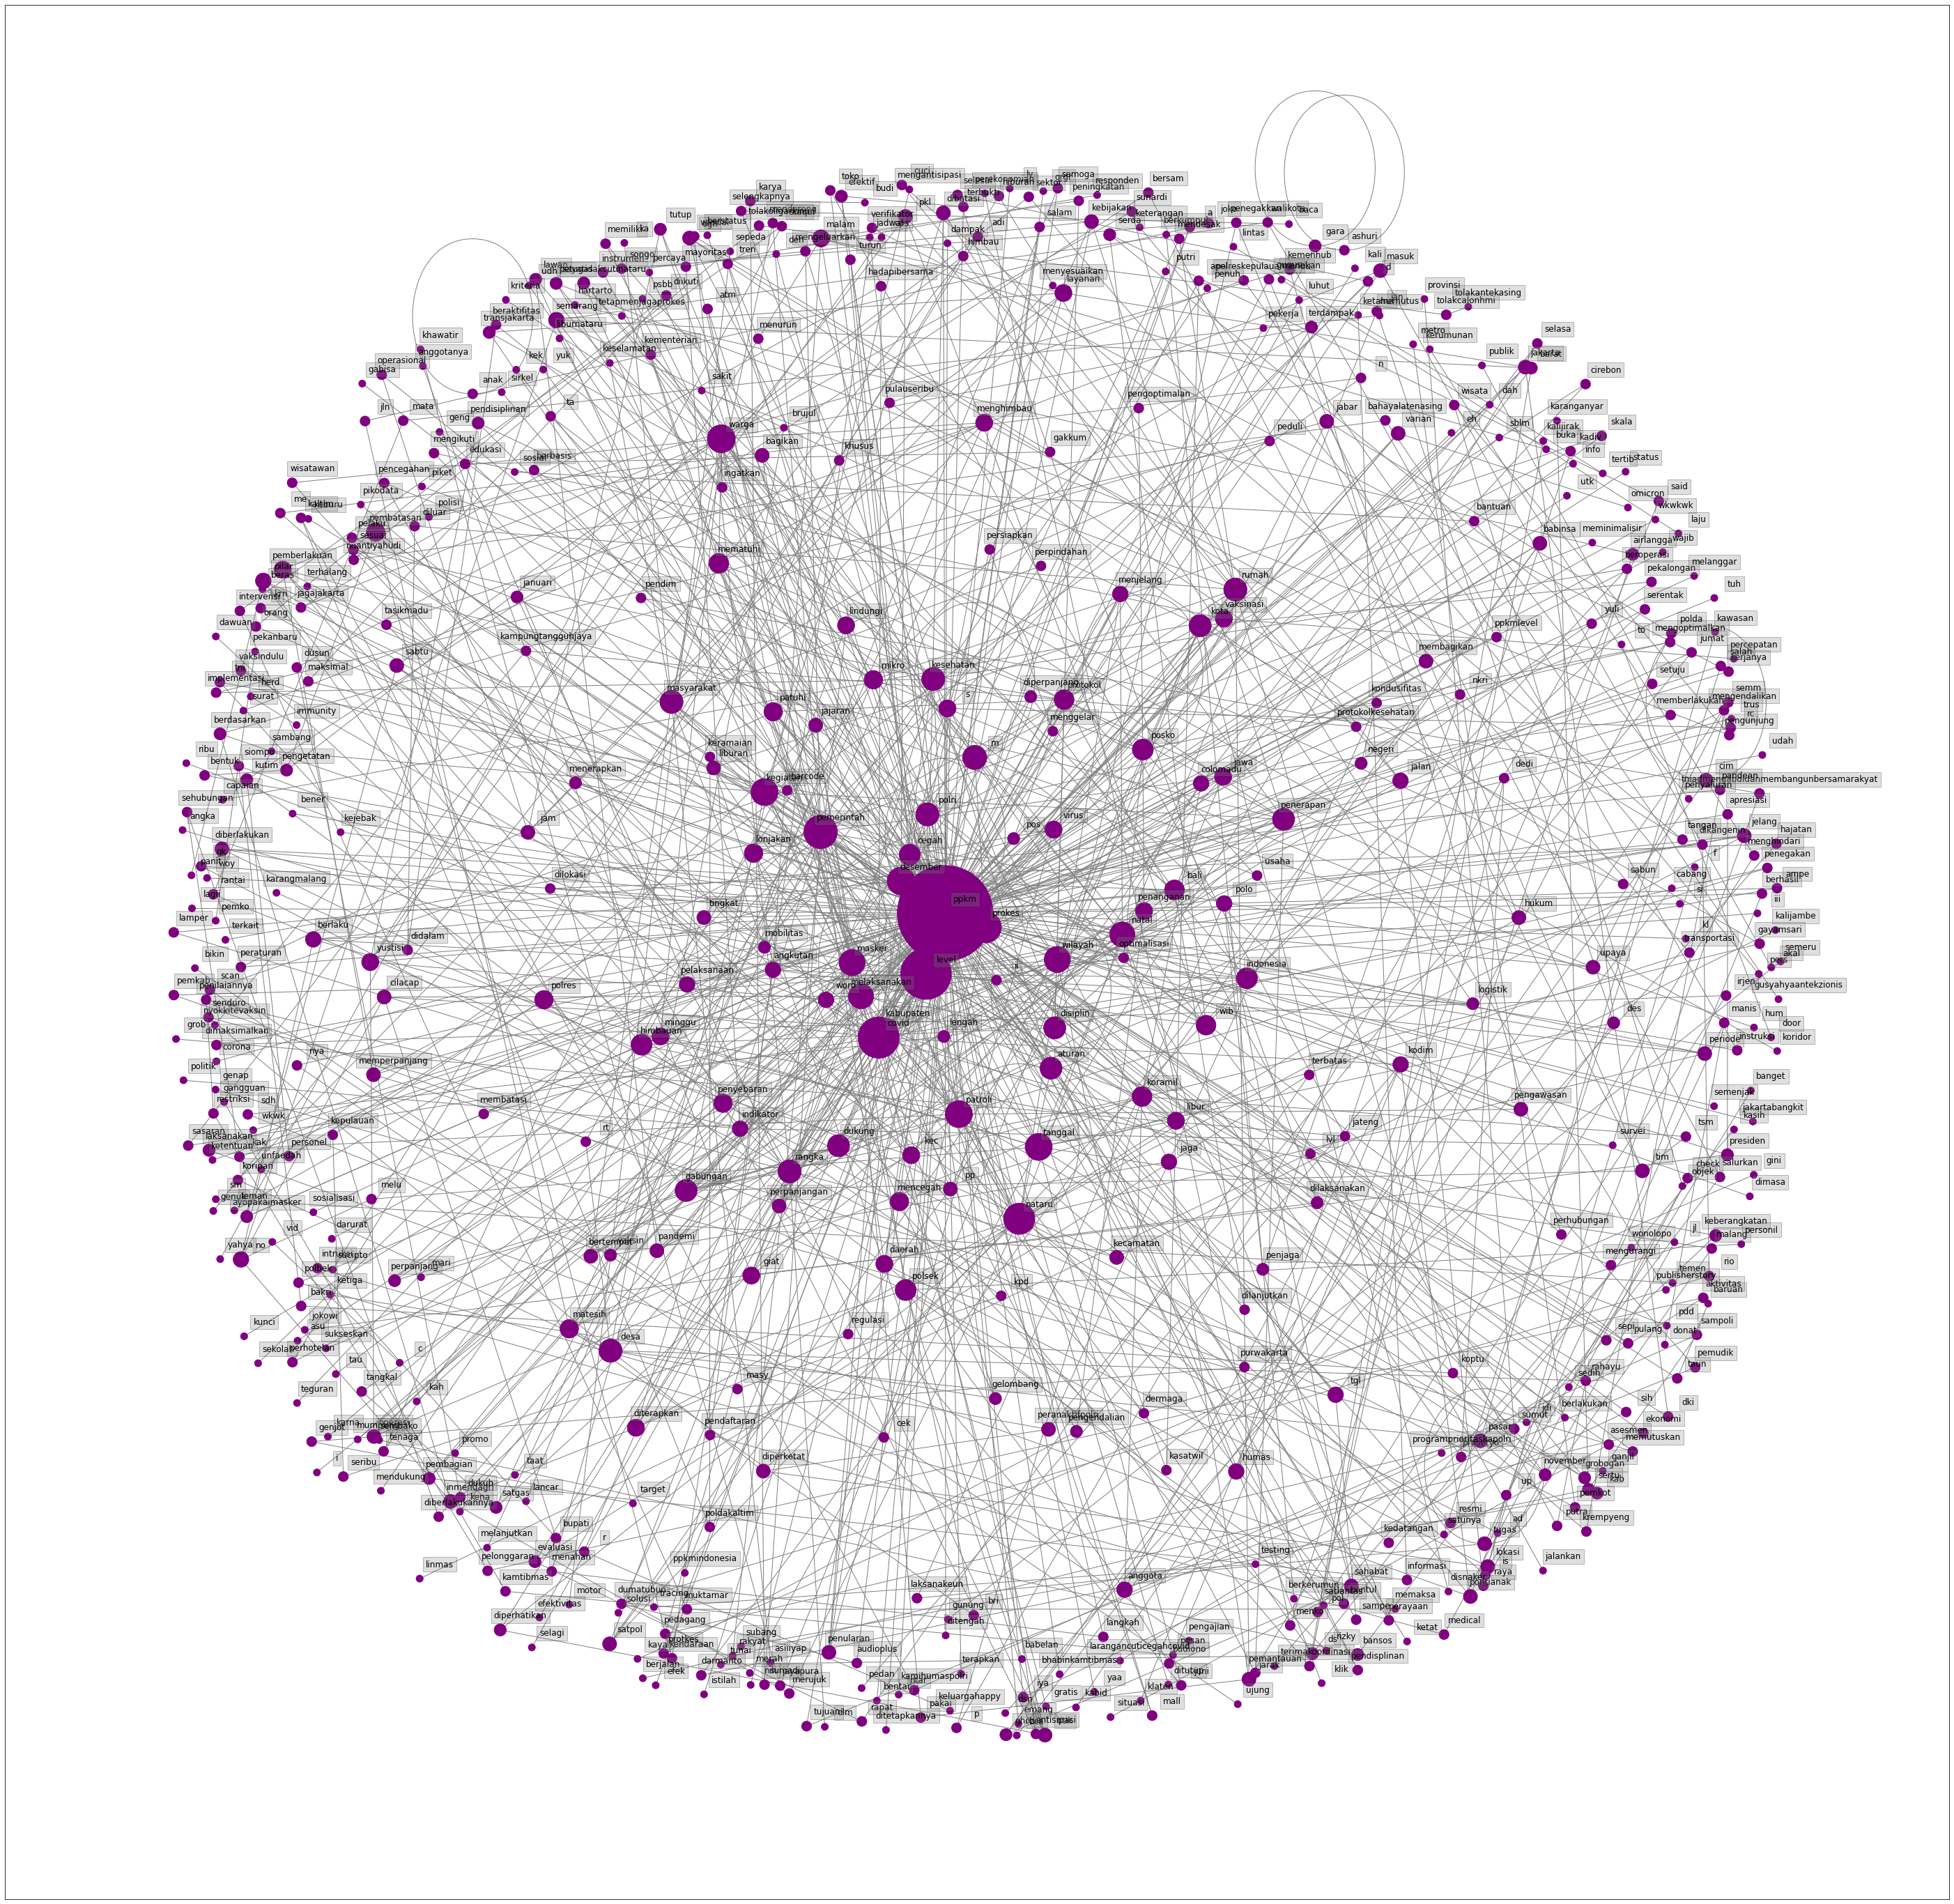

In [126]:
plotNetwork(df_bigram_sort)

Pada visualisasi di atas, dapat diperoleh bahwa kebijakan ppkm jawa-bali menjadi pusat perbincangan warganet. Tidak nampak opini yang yang terpisah secara signifikan.

## 8. Kesimpulan

Telah dilakukan pencarian, pembersihan, pengolahan, dan anilisis data twitter. Pencarian dan pembersihan data nampaknya cukup dilakukan dengan baik. Diperoleh 2030 data dari twitter pada rentang waktu 3-6 desember 2021. Karena ada duplikasi data, hanya diolah sebanyak 2000 twitter. Pada data tersebut 
didapat beberapa informasi berikut:
- Masyarakat membincarakan kebijakan ppkm di jawa - bali yang hendak diterapkan oleh pemerintah di momen libur natal dan awal tahun baru. Masyarakat secara umum menyambut positif kebijakan ini dengan indikasi nilai rata-rata sentimen di atas nol.
- Pada kelompok dengan sentimen positif terdapat himbauan kepada warganet dan aparat untuk menerapkan protokol kesehatan selama ppkm berlangsung untuk menekan penyebaran virus covid. Sedangkan pada kelompok dengan sentimen negatif ada indikasi keberatan atas pembatasan yang dilakukan kepada masyarakat. 
- Meskipun sentimen positif lebih dominan, tapi tweet dengan popularitas tinggi adalah tweet dengan sentimen negatif.
- Pembicaraan warganet dikelompokkan dibagi menjadi tiga topik, hasilnya adalah sebagai berikut 
    - topik 1 : kebijakan ppkm level 3 yang diterapkan di jawa - bali pada akhir momen libur nataru
    - topik 2 : dukungan warganet atas kebijakan ppkm
    - topik 3 : seruan kepada aparat polri, desa untuk melaksanakan protokol kesehatan pada pelaksanaan ppkm 
- Dengan ini, pemerintah punya dukungan moril dari warganet untuk menerapkan ppkm di akhir tahun. Meskipun pada akhirnya kebijakan ini dibatalkan oleh pemerintah. 


Saran :
- Perlu perbaikan algoritma untuk menentukan sentimen atas tweet, perbaikan itu bisa dilakukan dengan cara memperkaya dataset kata positif/negatif, mengubahnya ke dalam bentuk dasar, atau menghilangkan beberapa stopwords pada saat melakukan analisis sentimen.
- Untuk keabsahan algoritma, nampaknya perlu dilakukan perbandingan dengan modul (misal textblob) / algoritma lain yang sudah valid.  